In [1]:
#standard imports
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
categories = ['talk.politics.mideast',
 'rec.autos',
 'comp.sys.mac.hardware',
 'alt.atheism',
 'rec.sport.baseball',
 'comp.os.ms-windows.misc',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.med',
 'talk.politics.misc',
 'rec.motorcycles',
 'comp.windows.x',
 'comp.graphics',
 'comp.sys.ibm.pc.hardware',
 'sci.electronics',
 'talk.politics.guns',
 'sci.space',
 'soc.religion.christian',
 'misc.forsale',
 'talk.religion.misc']

Quick and simple way to avoid any hidden folders, etc.

In [4]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), categories = categories)

In [5]:
#X_train, X_test = train_test_split(newsgroups, test_size=0.25, random_state=42)

In [9]:
#tf-idf
vectorizer = TfidfVectorizer(stop_words = 'english')
X_train_tfidf = vectorizer.fit_transform(newsgroups.data)
# Getting the word list.
terms = vectorizer.get_feature_names()
# Number of topics.
ntopics=5

In [10]:
X_train_tfidf.shape

(11314, 101322)

In [11]:
# Linking words to topics
def word_topic(X_train_tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=X_train_tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

In [12]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
newsgroups_lsa = lsa.fit_transform(X_train_tfidf)

components_lsa = word_topic(X_train_tfidf, newsgroups_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)   

In [13]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

newsgroups_lda = lda.fit_transform(X_train_tfidf) 

components_lda = word_topic(X_train_tfidf, newsgroups_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [14]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
newsgroups_nmf = nmf.fit_transform(X_train_tfidf) 

components_nmf = word_topic(X_train_tfidf, newsgroups_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [15]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
             LSA            LDA         NNMF
0     just 121.7    just 114.45     don 4.44
0    like 120.83     don 113.26  people 4.43
0     don 117.88  people 110.65    just 4.25
0    know 116.99    like 110.03   think 3.84
0  people 103.84    know 103.83    like 3.79
0     think 99.4    think 98.84    know 3.29
0     does 94.41     does 83.98    good 2.85
0      use 83.31     good 81.11    time 2.75
0     good 83.25     time 80.21   right 2.29
0     time 81.73      god 72.04     did 2.25
Topic 1:
              LSA            LDA          NNMF
1    thanks 52.45        ax 7.04  windows 5.38
1   windows 49.54       edu 6.35   thanks 4.71
1      card 35.38      pitt 5.63    drive 3.73
1     drive 34.65      know 5.63     card 3.52
1      file 27.14      just 5.62     know 3.35
1        dos 26.8     cadre 5.52     does 3.35
1      mail 26.59       geb 5.49      use 3.22
1       use 26.23       dsl 5.47      dos 2.84
1  software 23.99  shameful 5.46     like 2.67
1        pc 23.35

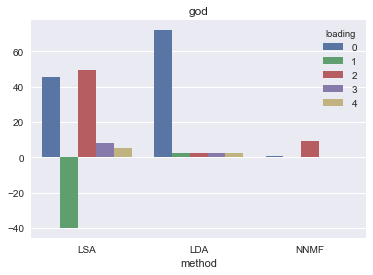

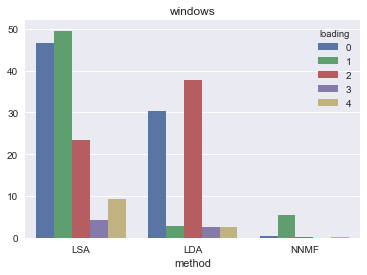

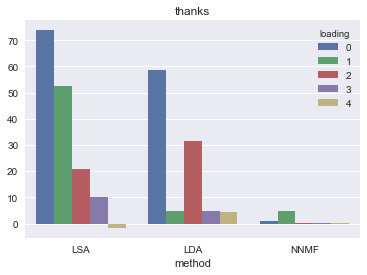

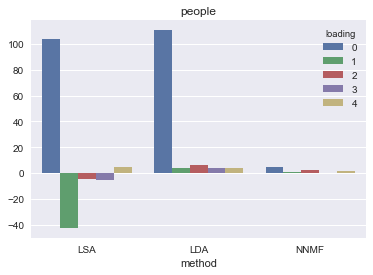

In [16]:
# The words to look at.
targetwords=['god','windows','thanks','people']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


I think in this case LSA and LDA performed most strongly with this dataset.  I would improve it by adding additional stopwords to get some of the topics that seemed prevalent out (e.g. "edu"). I think this would strengthen the dataset quite a bit.